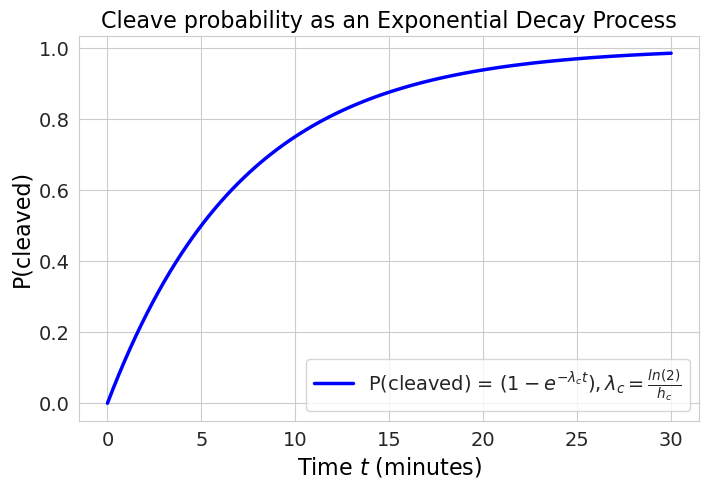

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
L0 = 1 # Initial length of the candle in units (e.g., centimeters)
h = 5   # Half-life in minutes

# Decay constant
lambda_ = np.log(2) / h

# Time settings
time = np.linspace(0, 30, 100)  # Simulate for 180 minutes

# Exponential decay formula
p_spliced = L0 * (1-np.exp(-lambda_ * time))

# Plotting
plt.figure(figsize=(8, 5))
# write label in large font
font = {'color':  'black',
        'weight': 'normal',
        'size': 16
        }
plt.plot(time, p_spliced, label='P(cleaved) = $(1 - e^{-\lambda_c t}), \lambda_c=\\frac{ln(2)}{h_c}$', color='blue', linewidth=2.5)
plt.title('Cleave probability as an Exponential Decay Process', fontdict=font)
plt.xlabel('Time $t$ (minutes)', fontdict=font)
plt.ylabel('P(cleaved)', fontdict=font)
plt.legend(prop={'size': 14})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True)
plt.show()


In [8]:
import os
# print(os.getcwd())
# os.chdir('/gladstone/engelhardt/home/hvu/source/RNA_rates/splicingrates/simulations')
import numpy as np
import scipy
import seaborn as sns
from transcription.experiment import Experiment
from transcription.transcripts import calculate_enlongated_endsite
from transcription import simulate_multiple_experiments as sim
import visualize_simulations as viz
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
import helper
import estimate_elongation as estElong
import pandas as pd 
ONE_KB=1000
SIM_FEAT_LEN = 5000 # length of one feature in the simulation
SEED = 9999
np.random.seed(SEED)

In [2]:
target_exp = 5
num_total_transcript_millions = 100
degrade_rate = 0.00
intron_h = 5
PAS_h=5
RTR=500
lambda_init = 2 # average number of burst events per minute (burst event is the event where a burst_size transcripts are created around the same time)
burst_size = 10 # number of transcripts created in a burst event
wiggle_room = 0.3 # the wiggle room for the burst event. See the comments in function Experiment.init_bursting_transcripts to understand the meaning of this parameter. If not sure, don't modify it.
# if I want to simulate situation such that there is no read being generated from fragments (only the whole transcripts are sequenced), the following parameters should be set carefully:
eta_val=helper.DFT_ETA_VALUE  # the scale fo weibull distribution for the fragment length
insertsize_min = 200  #filter fragments minimum length
insertsize_max = 300  # filter fragments maximum length
read_length = 150 # the length of the reads
frag_func= 'weibull_edge' # whether we will simulate the fragmentation of transcripts based on the weibull distribution or the uniform fragmentation method
unif_avg_frag_len=250 # the desired average fragment length if we use the uniform fragmentation method
# if I set the read values to -1, the program will just generate fragments and not get rid of any portion of the fragments.
simulate_cleavage=False ## for this problem, we don't need to simulate cleavage because we really only care about calculating the elongation speed of the transcripts. We skip splicing and cleavage for now.
PDB = False  # whether we simulate a system where there is no existing transcripts, and instead we used PDB to stop the transcripts from elongation, and let the elongation to start PDB_time minutes before we introduce the first tag
label_time = np.arange(4) if PDB else np.arange(3)
time_interval=5
label_time = time_interval*label_time
num_timepoints = len(label_time)
max_time_for_equilibrium = 50
save_folder = None # './exon2_4Fold/'
gtf_df = sim.create_variable_gtf_df(nExons=3, elong_fold_list = [1.0,1,2.0,1,1.0], length_fold_list = [5,1,5,1,5], SIM_FEAT_LEN=ONE_KB)
gtf_df = gtf_df[gtf_df['is_intron'] == False]
gtf_df['start'] = gtf_df.loc[0, 'start'] + np.cumsum(gtf_df['length']) - gtf_df['length']
gtf_df['end'] = gtf_df['start'] + gtf_df['length']
gtf_df['time'] = (gtf_df['end'] - gtf_df['start']) / gtf_df['txrate'] / ONE_KB  # time to traverse the feature

exp_list = sim.generate_exp_given_one_gtf(gtf_df, save_folder= save_folder, label_time = label_time, target_exp=target_exp, num_total_transcript_millions = num_total_transcript_millions, lambda_init = lambda_init , burst_size = burst_size, wiggle_room = wiggle_room,eta_val=eta_val, insertsize_min=insertsize_min, insertsize_max=insertsize_max, read_length=read_length, simulate_cleavage=simulate_cleavage, PDB=PDB, max_time_for_equilibrium=max_time_for_equilibrium, frag_func=frag_func)

inside generate_exp_given_one_gtf
before adding new experiments
399
499
579


#fee6e3
#fcbfbe
#faa2b6
#fee6e3
#fcbfbe
#faa2b6
#fee6e3
#fcbfbe
#faa2b6


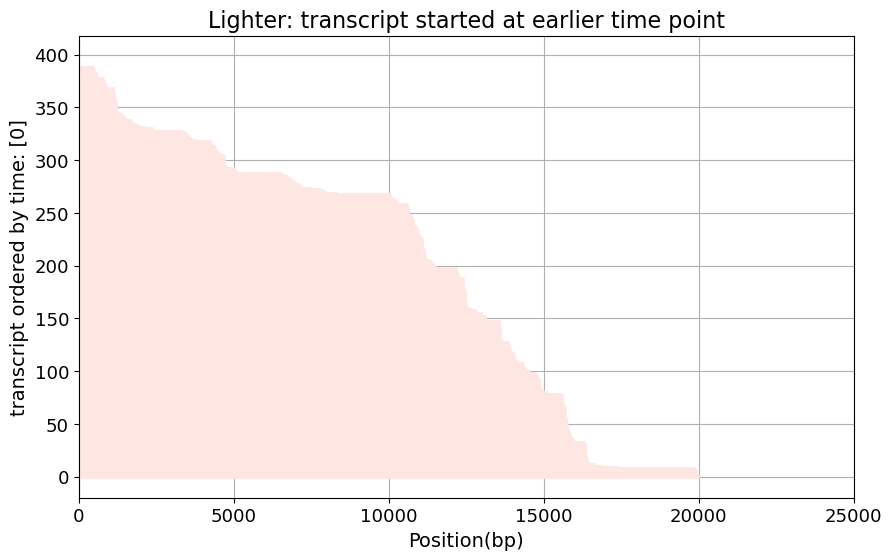

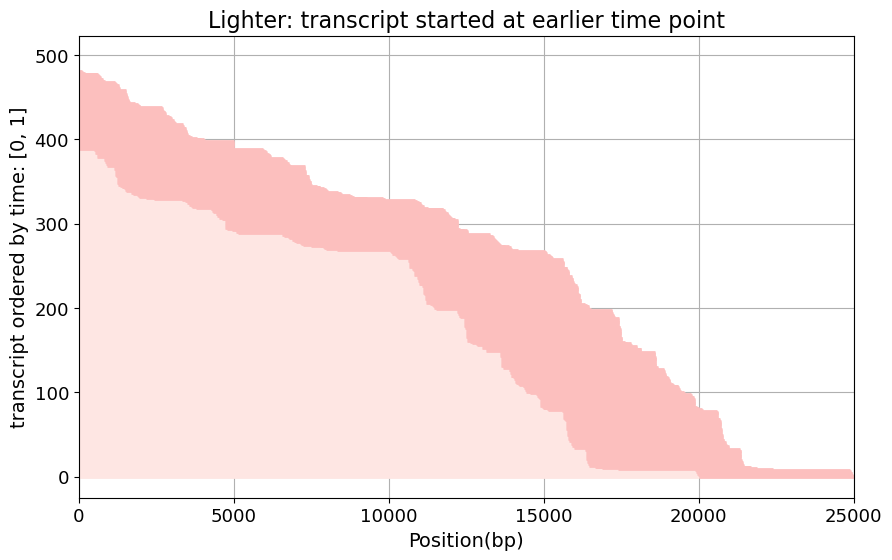

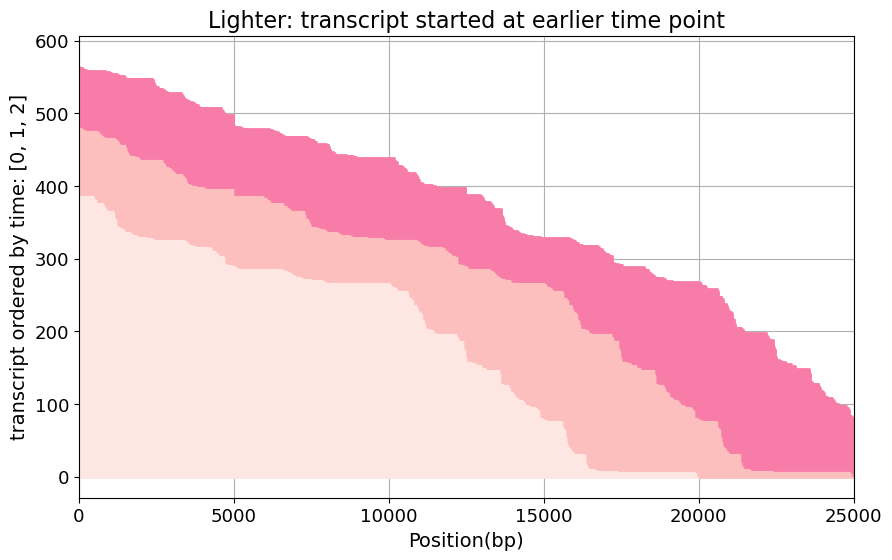

In [16]:
import importlib
importlib.reload(viz)
for i in range(len(exp_list)):        
    viz.plot_all_times_endsite(exp_list[:(i+1)], lower_idx=0, upper_idx=720, line_width=2, y_order_by_time=False, xlim=(0,25000))

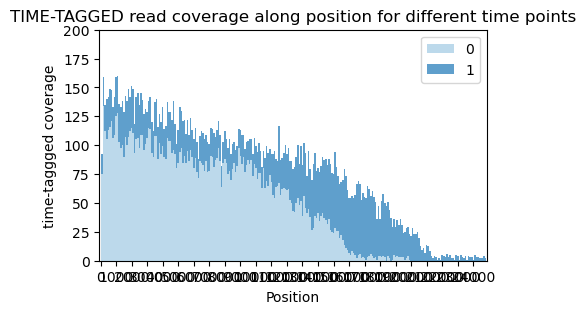

In [5]:
import importlib
importlib.reload(viz)
coverage_df = viz.plot_timeTagged_read_coverage(exp_list[0:2], smooth_N=1, gap_N=100, xaxis_N=10, width=1, stacked=True, ylim=(0,200), xlim=(0,30000), time_to_plot=[0,1])

If startT_idx!= endT_idx-1 thenthe plot may be very wrong. I do not fix it yet


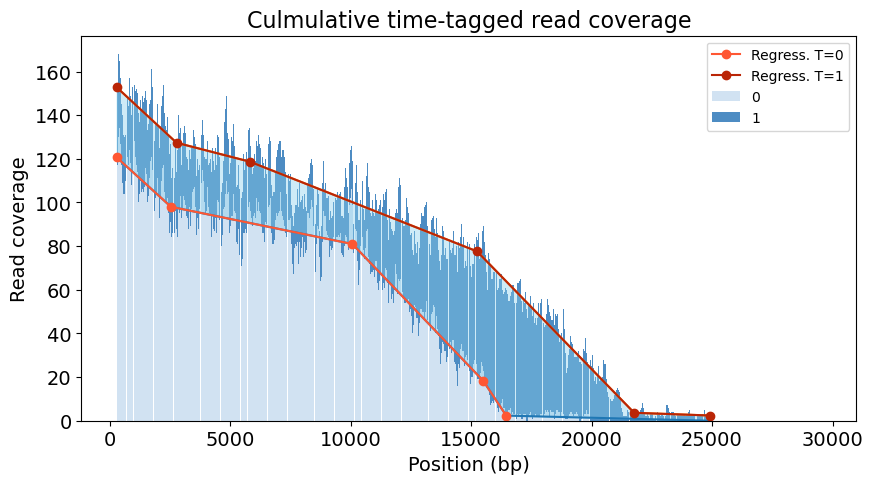

In [20]:
endpoint_df = viz.get_endpoints_across_time(exp_list) # there can be transcripts where all the endpoints are 0 across timepoints. That is because of how the init_new_transcript function works: the last batch of transcripts creaited are time_since_prev=0, so they don't elongate. 
coverage_df = viz.count_timeDep_read_coverage(exp_list[-1], endpoint_df, N=1, num_timepoints=len(exp_list))
import importlib
importlib.reload(estElong)
def plot_piecewise_regression_multiple_timepoints(coverage_df, startT_idx:int, endT_idx:int, max_segments=15, xlim=None):
    print('If startT_idx!= endT_idx-1 thenthe plot may be very wrong. I do not fix it yet')
    # coverage_df = (coverage_df.loc[:3000, :]).copy()
    coverage_df = estElong.convert_gene_to_KB(coverage_df, convert_to_KB=False)
    coverage_df = estElong.clean_edgeEffect_region_from_coverage(coverage_df, trim_N=300)
    px0, py0, px1, py1, x0_, x1_, _ = estElong.estimate_endpoints_acrossTime(coverage_df, startT_idx, endT_idx, max_segments, gapN=10)
    plot_df = coverage_df.loc[::10] # we do not need to plot every datapoints
    cmap = sns.color_palette('Blues', n_colors=3)
    colors = [cmap[i] for i in range(3)]
    fig, ax = plt.subplots(figsize=(10,5))
    width = 9.5
    ax.bar(plot_df['position'], plot_df[startT_idx], color=colors[0], alpha=0.8, label=startT_idx, width=width)
    ax.bar(plot_df['position'], plot_df[endT_idx], color=colors[2], bottom=plot_df[startT_idx], alpha=0.8, label=endT_idx, width=width)
    #plot the area between the two regression line
    x_common = np.union1d(px0, px1)
    # Interpolate y values for this common x array
    py0_interp = np.interp(x_common, px0, py0)
    py1_interp = np.interp(x_common, px1, py1)
    ax.plot(x_common, py0_interp)
    ax.plot(x_common, py1_interp)
    ax.fill_between(x_common, py0_interp, py1_interp, color='skyblue', alpha=0.4)
    ax.plot(px0[:-1], py0[:-1], '-o', color = '#FF5733', label=f'Regress. T={startT_idx}')  # red
    ax.plot(px1, py1, '-o', color='#BA2506', label=f'Regress. T={endT_idx}')  # red
    # ax.plot(x0, y0, '-or', color='green', alpha=0.1)
    # ax.plot(x1, y0, '-or', color='green', alpha=0.1)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.set_xlabel('Position (bp)', fontsize=14)
    ax.set_ylabel('Read coverage', fontsize=14)
    ax.set_title('Culmulative time-tagged read coverage', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.legend()
    return px0, py0, px1, py1, x0_, x1_


def draw_distance_travelled(gtf_df, time_interval, x0_,x1_):
    
    gtf_df = gtf_df.reset_index(drop=True)  # this line is very very important. If I dont do it, the code will mess with the calculation of the distance travelled. This is reset in the function simulate_multiple_experiments.py
    # given the start point, calculate the distance travelled in 5 minutes given the ground truth of the elongation speed
    df = pd.DataFrame({'start': x0_})
    df['end'] = df['start'].apply(lambda x: calculate_enlongated_endsite(x, gtf_df, time_interval))
    df['trueD'] = df['end'] - df['start']
    df['predD'] = x1_ - x0_
    # plot the barplot with x axis as start, and y axis as D
    plt.figure(figsize=(8, 5))
    plt.bar(df['start'], df['trueD'], width=50, label = 'TrueD', alpha=0.2)
    plt.bar(df['start'], df['predD'], width=50, label = 'PredD', alpha=0.2)
    plt.xlabel('Start position (bp)', fontsize=14)
    plt.ylabel('Distance travelled in 5 minutes (bp)', fontsize=14)
    plt.title('Distance travelled in 5 minutes', fontsize=16)
    # set the font size of the tick labels
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.legend()
    plt.show()
    return 
px0, py0, px1, py1, x0, x1 = plot_piecewise_regression_multiple_timepoints(coverage_df, startT_idx=0, endT_idx=1, max_segments=15, xlim=None)

# draw_distance_travelled(gtf_df, time_interval, x0, x1)

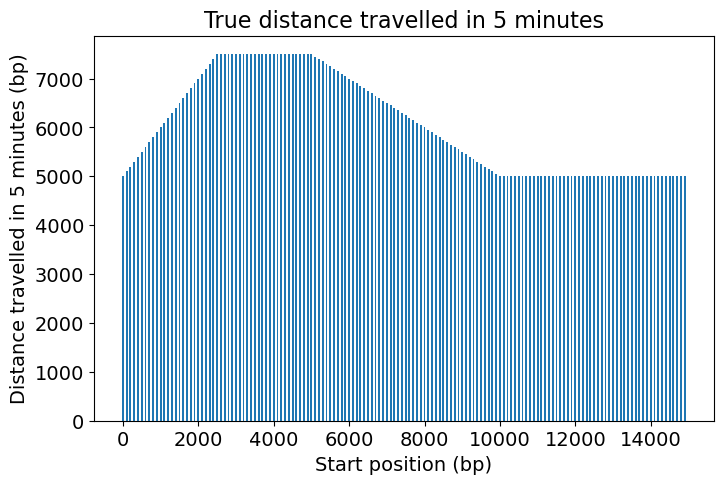

In [11]:
# next let's figure out to plot the TRUE distance travelled plot between time t and 1
start = np.arange(0,15000, 100)
gtf_df = gtf_df.reset_index(drop=True)  # this line is very very important. If I dont do it it will mess with the calculation of the distance travelled. This is reset in the function simulate_multiple_experiments.py
# given the start point, calculate the distance travelled in 5 minutes given the ground truth of the elongation speed
df = pd.DataFrame({'start': start})
df['end'] = df['start'].apply(lambda x: calculate_enlongated_endsite(x, gtf_df, time_interval))
df['trueD'] = df['end'] - df['start']
# plot the barplot with x axis as start, and y axis as D
plt.figure(figsize=(8, 5))
plt.bar(df['start'], df['trueD'], width=50)
plt.xlabel('Start position (bp)', fontsize=14)
plt.ylabel('Distance travelled in 5 minutes (bp)', fontsize=14)
plt.title('True distance travelled in 5 minutes', fontsize=16)
# set the font size of the tick labels
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

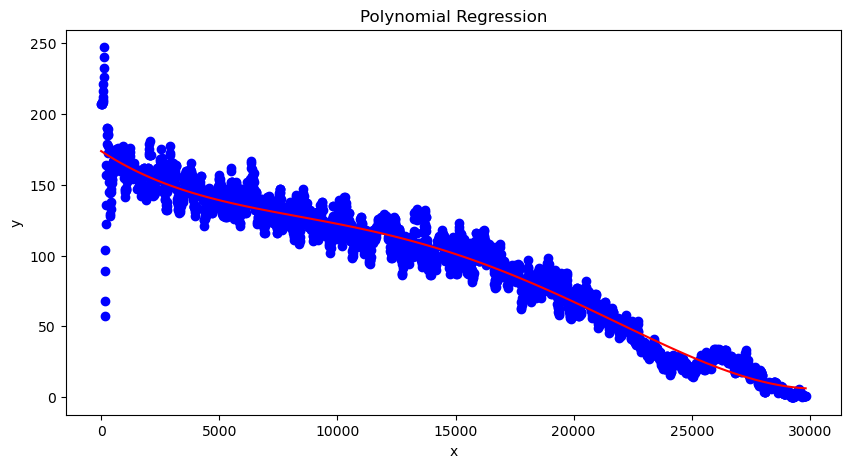

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Sample data
# coverage_df = viz.count_timeDep_read_coverage(exp_list[-1], endpoint_df, N=1, num_timepoints=len(exp_list))
# coverage_df = estElong.convert_gene_to_KB(coverage_df, convert_to_KB=False)
# coverage_df = estElong.clean_coverage_df_to_culmulative_coverage(coverage_df, startT_idx=0, endT_idx=1, gapN=10)
x = coverage_df['position'].values
y = coverage_df[1].values

# Transforming data
poly_features = PolynomialFeatures(degree=4)  # You can adjust the degree
X_poly = poly_features.fit_transform(x.reshape(-1, 1))

# Fit a polynomial regression model
model = LinearRegression().fit(X_poly, y)

# Predict and plot
x_range = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_pred = model.predict(poly_features.transform(x_range))
fig, ax = plt.subplots(figsize=(10,5))
plt.scatter(x, y, color='blue')
plt.plot(x_range, y_pred, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Polynomial Regression')
plt.show()


Trying degree 1...


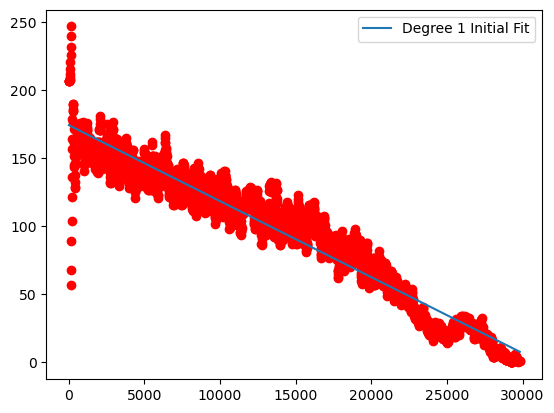

0.09305693123634351
Trying degree 2...


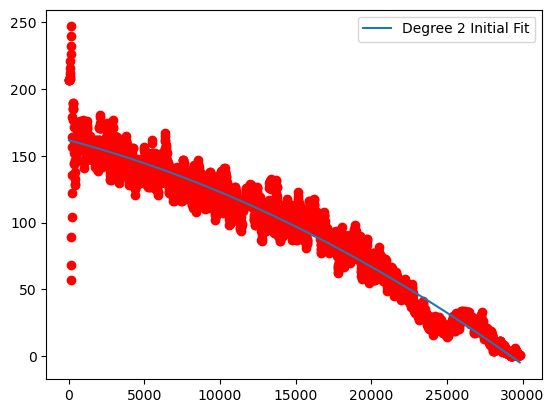

0.08236783905509433
Trying degree 3...


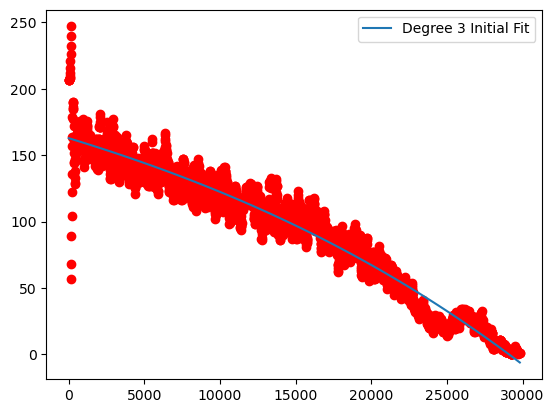

4774818.912003059
No suitable polynomial degree found.
